In [13]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

# Read in data and do basic massaging

In [14]:
df_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0,101.0,2,3,5,7,8,8,...,59,70,75,82,114,147,177,212,272,322
1,NaN,Japan,36.0,138.0,2,1,2,2,4,4,...,639,639,701,773,839,825,878,889,924,963


In [15]:
df = df_raw.drop(['Lat', 'Long'], axis=1)                   # drop the Lat/Lon columns
df = df[df['Country/Region'] == 'US']                       # filter all but US out
df = df.drop('Country/Region', axis=1)
# rotate data so states are column headers and dates are row index
df = df.set_index('Province/State')     # set index (for rows) to state
df = df.stack().unstack(level=0)
df.index.rename('Date', inplace=True)

# drop the county names that stopped receiving data as of 3/9
df = df.drop(df.columns[df.columns.str.contains(',')], axis=1)
# drop the two cruise ships
df = df.drop(['Diamond Princess', 'Grand Princess'], axis=1)
# drop rows before 3/10 since states didn't get data before then
df = df.loc['3/10/20':,:]
df

Province/State,Washington,New York,California,Massachusetts,Georgia,Colorado,Florida,New Jersey,Oregon,Texas,...,Montana,New Mexico,North Dakota,South Dakota,West Virginia,Wyoming,Alabama,Puerto Rico,Guam,Virgin Islands
Date,,,,,,,,,,,,,,,,,,,,,
3/10/20,267,173,144,92,17,15,15,15,15,13,...,0,0,0,0,0,0,0,0,0,0
3/11/20,366,220,177,95,23,34,28,23,19,21,...,1,3,0,8,0,0,0,0,0,0
3/12/20,442,328,221,108,31,45,35,29,24,27,...,1,5,1,8,0,1,0,0,0,0
3/13/20,568,421,282,123,42,49,50,29,30,43,...,1,10,1,8,0,1,5,0,0,0
3/14/20,572,525,340,138,66,101,76,69,32,57,...,5,10,1,9,0,2,6,3,0,1
3/15/20,643,732,426,164,99,131,115,98,36,72,...,7,13,1,9,0,3,12,5,3,1
3/16/20,904,967,557,197,121,160,155,178,39,85,...,7,17,1,10,0,3,29,5,3,1
3/17/20,1076,1706,698,218,146,160,216,267,66,110,...,9,23,3,11,1,11,39,5,3,2
3/18/20,1014,2495,751,218,199,184,314,267,68,173,...,11,23,6,11,1,15,46,5,5,2


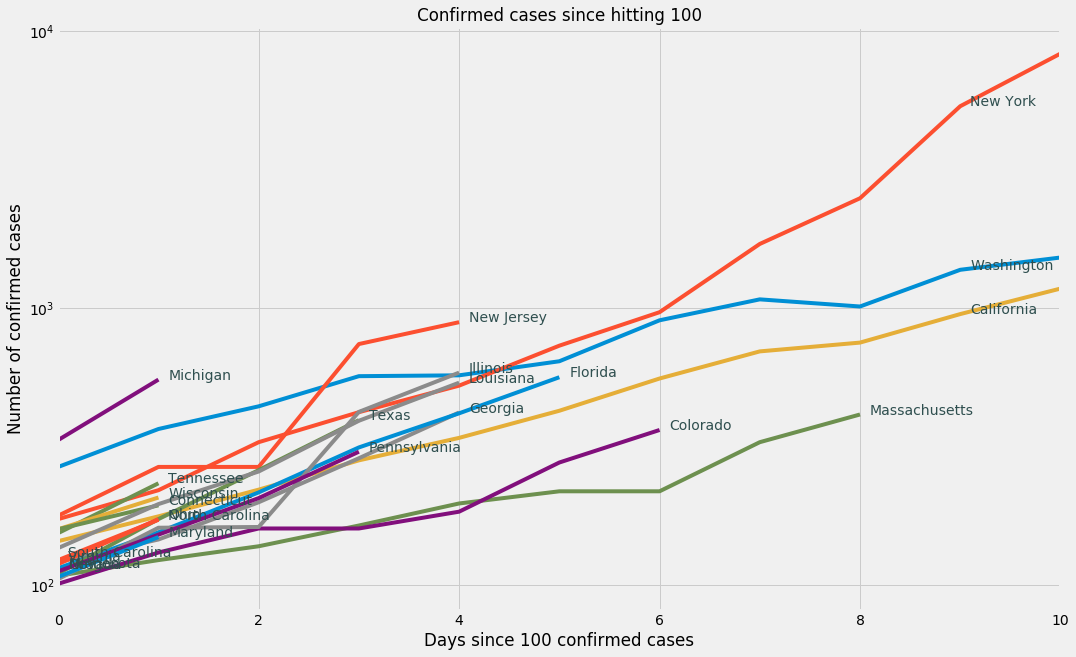

In [18]:
threshold = 100
daysSince = pd.DataFrame(index=range(0,len(df.index)))
for location in df.columns:
    # create list of data once above 'threshold'
    tempList = [df.loc[date, location] 
                              for date in df[location].index 
                              if df.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince[location] = tempListFilled

daysSince = daysSince.dropna(axis=0, how='all')
ax = daysSince.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Confirmed cases since hitting {}'.format(threshold), fontsize='large')
ax.set_xlabel('Days since {} confirmed cases'.format(threshold), fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')


for location in daysSince.columns:
    previous = 100
    for xdays, datapoint in enumerate(daysSince[location]):
        if pd.isnull(datapoint) or (xdays == len(daysSince[location])-1):
            ax.annotate(location, (xdays-1, previous), 
                        xytext=(10,0), 
                        textcoords='offset pixels',
                        family='sans-serif', fontsize=14, color='darkslategrey')
            break
        else:
            previous = datapoint
            
plt.show()

In [19]:
df2 = df_raw.drop(['Lat', 'Long'], axis=1)
df2 = df2[df2['Country/Region'] == 'US']
df2 = df2.drop('Country/Region', axis=1)
df2 = df2.drop(df2.index[df2['Province/State'].str.contains(",")], axis=0)
df2 = df2.drop(df2.index[df2['Province/State'] == 'Diamond Princess'])
df2 = df2.drop(df2.index[df2['Province/State'] == 'Grand Princess'])
df2 = df2.melt(id_vars='Province/State')
df2.head()

,Province/State,variable,value
0,Washington,1/22/20,0
1,New York,1/22/20,0
2,California,1/22/20,0
3,Massachusetts,1/22/20,0
4,Georgia,1/22/20,0


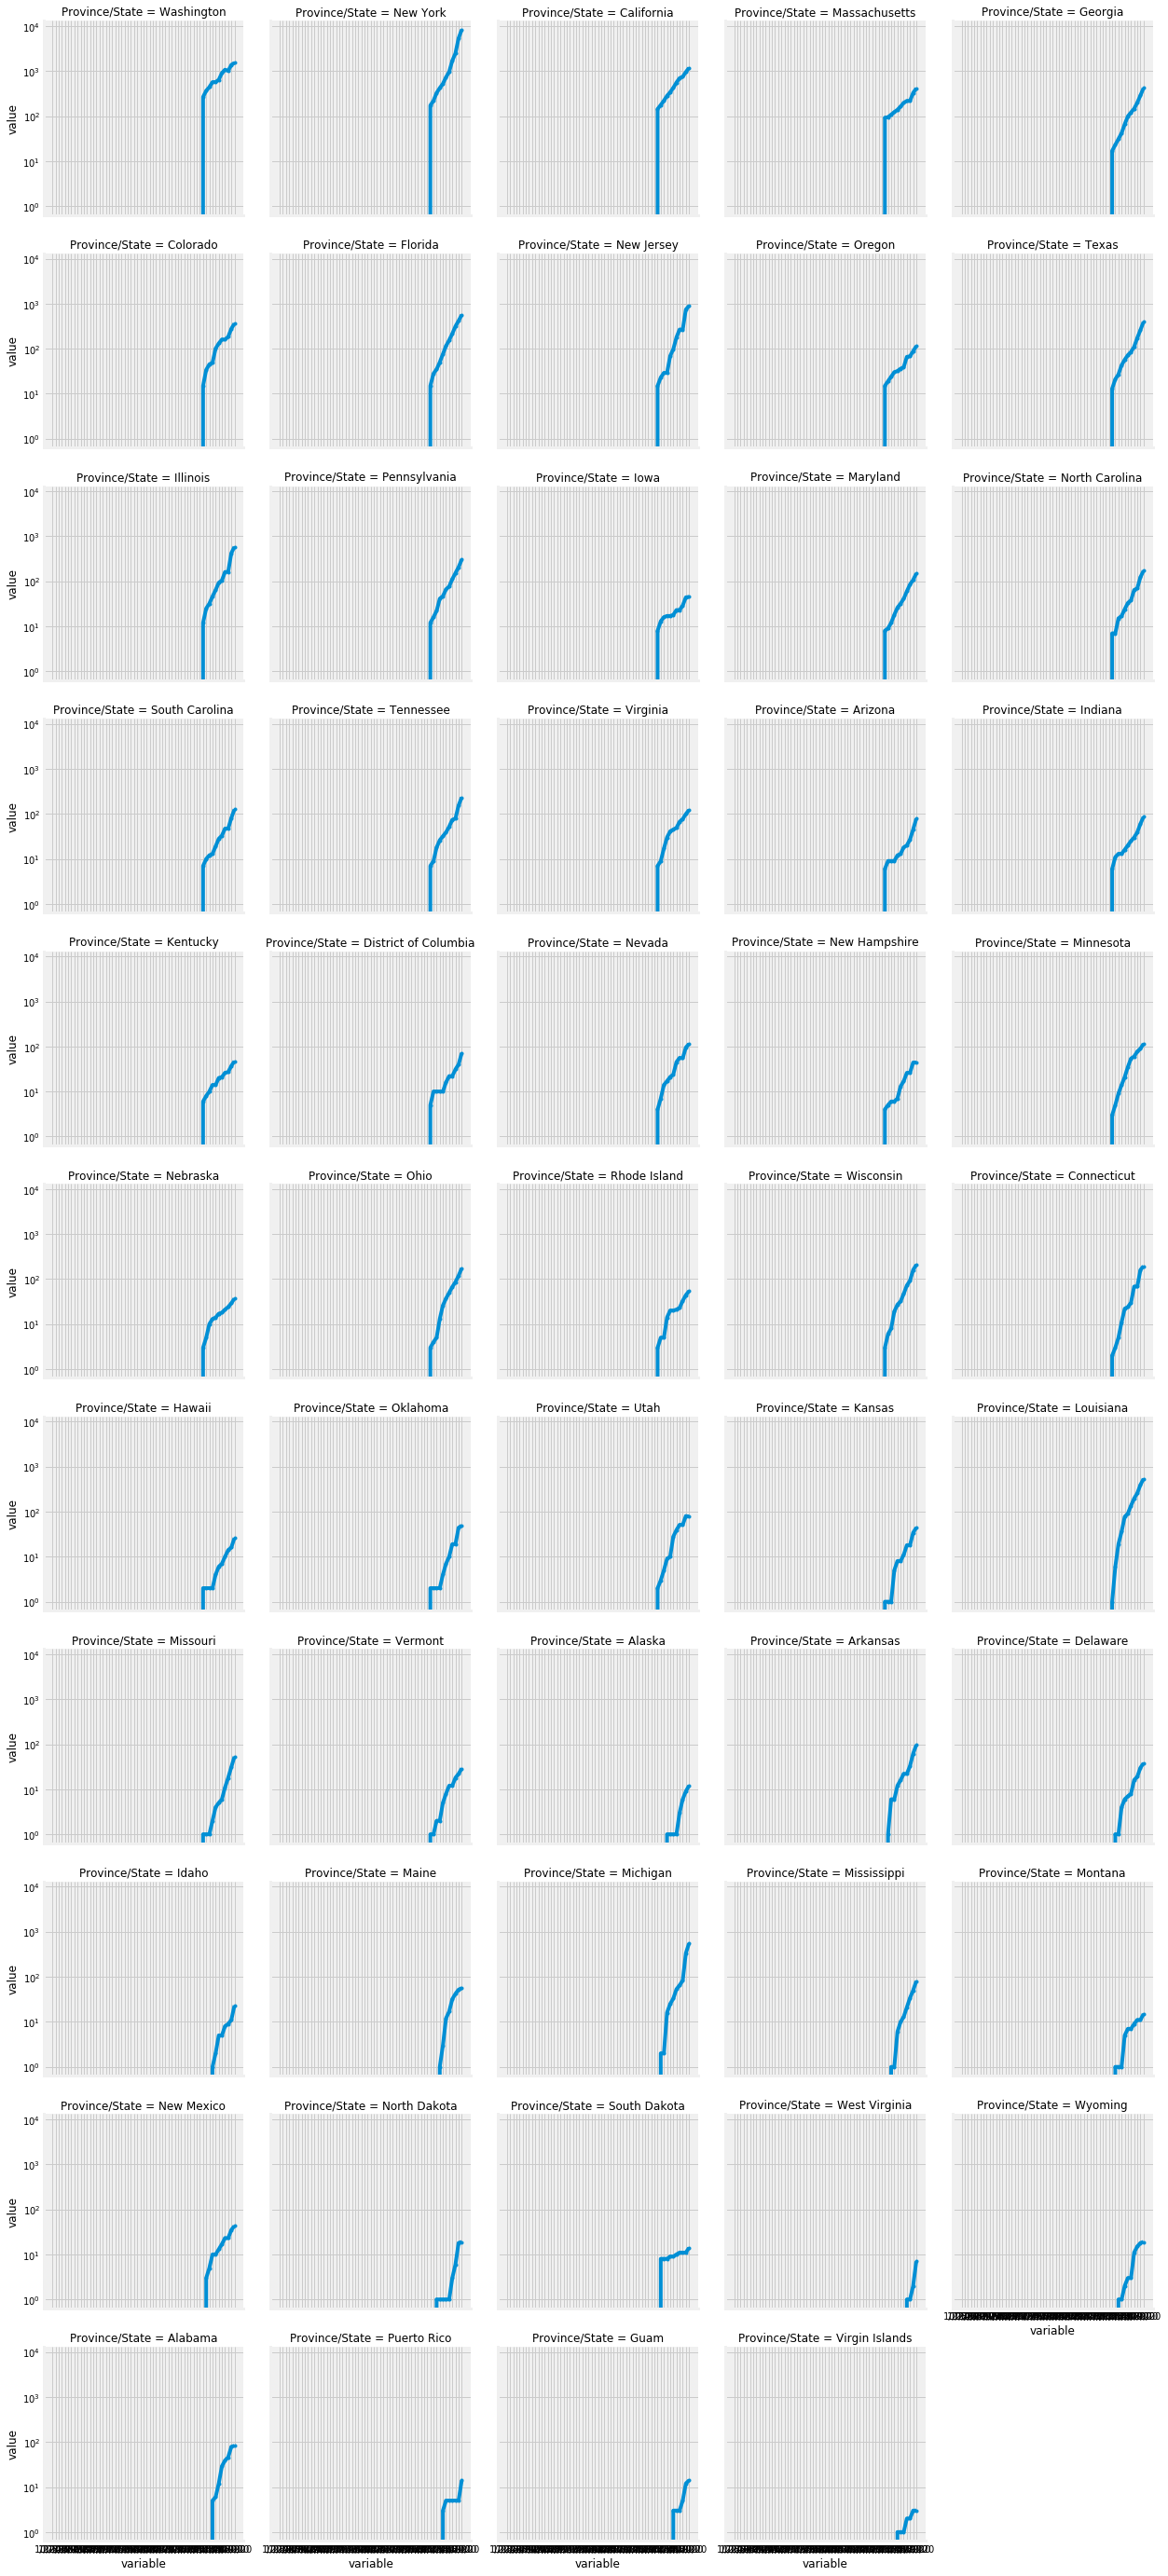

In [12]:
g = sns.FacetGrid(df2, col="Province/State", col_wrap=5, height=3.5)
plt.yscale('log')
g = g.map(plt.plot, 'variable', 'value', marker=".")

In [4]:
df2 = df_raw.drop(['Lat', 'Long'], axis=1)
df2 = df2[df2['Country/Region'] == 'US']
df2 = df2.drop('Country/Region', axis=1)
df2 = df2.drop(df2.index[df2['Province/State'].str.contains(",")], axis=0)
df2 = df2.drop(df2.index[df2['Province/State'] == 'Diamond Princess'])
df2 = df2.drop(df2.index[df2['Province/State'] == 'Grand Princess'])
#df2 = df2.melt(id_vars='Province/State')
df2 = df2.set_index('Province/State')     # set index (for rows) to state, leaving only dates in columns
df2 = df2.stack().unstack(level=0)        # rotate dates into row index, then take state back out and into col
df2.index.rename('Date', inplace=True)
df2 = df2.loc['3/10/20':,:]               # eliminate dates before 3/10
df2.stack()

Date     Province/State
3/10/20  Washington        267
         New York          173
         California        144
         Massachusetts      92
         Georgia            17
                          ... 
3/20/20  Wyoming            19
         Alabama            83
         Puerto Rico        14
         Guam               14
         Virgin Islands      3
Length: 594, dtype: int64

In [5]:
g = sns.FacetGrid(df2.stack(), col='Province/State')
g = g.map(plt.plot, 'Date', marker=".")

KeyError: 'Province/State'

In [6]:
att = sns.load_dataset("attention")
att.head()

,Unnamed: 0,subject,attention,solutions,score
0,0,1,divided,1,2.0
1,1,2,divided,1,3.0
2,2,3,divided,1,3.0
3,3,4,divided,1,5.0
4,4,5,divided,1,4.0


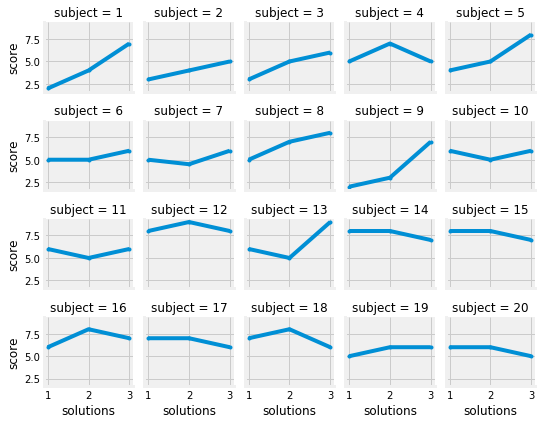

In [7]:
g = sns.FacetGrid(att, col="subject", col_wrap=5, height=1.5)
g = g.map(plt.plot, "solutions", "score", marker=".")